### Задание 1 .
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

Mobile Games AB Testing with Cookie Cats

### Решение:
Подгрузим библиотеки и датасет.

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

df = pd.read_csv('cookie_cats.csv')
print("The content of the file is:\n", df)


The content of the file is:
         userid  version  sum_gamerounds  retention_1  retention_7
0          116  gate_30               3        False        False
1          337  gate_30              38         True        False
2          377  gate_40             165         True        False
3          483  gate_40               1        False        False
4          488  gate_40             179         True         True
...        ...      ...             ...          ...          ...
90184  9999441  gate_40              97         True        False
90185  9999479  gate_40              30        False        False
90186  9999710  gate_30              28         True        False
90187  9999768  gate_40              51         True        False
90188  9999861  gate_40              16        False        False

[90189 rows x 5 columns]


Датасет содержит данные с ID пользователя, распределением по версиям игры с размещением ворот на 30-м уровне и в новой версии игры с размещением ворот на 40-м уровне. В датасете есть данные о количестве сыгранных раундов и информация о том, вернулся ли пользователь в игру через 1 день и через 7 дней.<br>
В A/B тесте рассмотрим влияние на удержание игроков.
По эти данным сформулируем нулевую гипотезу:<br>
**Перенос ворот в игре с 30-го на 40-й уровень не имеет статистически значимого влияния на удержание игроков.**<br>
Для начала нужно проверить данные на корректрость.

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


В качестве проверки на корректрность посмотрим, есть ли примерно одинаковое количество игроков в каждой группе A/B.

In [64]:
df.groupby('version')['version'].count()

version
gate_30    44700
gate_40    45489
Name: version, dtype: int64

Контрольная и тестовая группы имеют примерно равное количество пользователей.
Посмотрим распределение игровых раундов.

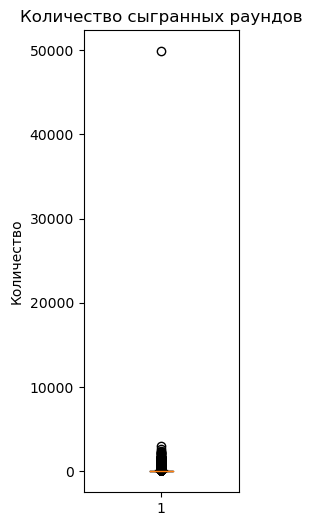

In [65]:
plt.figure(figsize=(2, 6))
plt.boxplot(df['sum_gamerounds'])
plt.ylabel('Количество')
plt.title('Количество сыгранных раундов');

График показывает, что в наборе данных существуют явные выбросы, поскольку один из игроков сыграл около 50000  игровых раундов. Скорее всего это «бот» или «баг».

In [66]:
df['sum_gamerounds'].describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

Около 50% игроков сыграли 16 игровых раундов, а 75% игроков сыграли 51 игровой раунд.
Удалим из датасета выброс, так как он сильно искажает расчеты.

In [67]:
df = df[df['sum_gamerounds'] < 40000]

In [68]:
df['sum_gamerounds'].describe()

count    90188.000000
mean        51.320253
std        102.682719
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max       2961.000000
Name: sum_gamerounds, dtype: float64

In [69]:
print("95 перцентиль данных составляет: ", ptiles[4], "раундов игры.","\n",
"Этому соответствует", df[df["sum_gamerounds"] <= ptiles[4]].shape[0], "игроков.")

95 перцентиль данных составляет:  221.0 раундов игры. 
 Этому соответствует 85706 игроков.


Но некоторые игроки после установки игры не сыграли ни одного раунда.

In [70]:
print ( "Игроки, которые не сыграли ни одного раунда с момента установки: " ,  df [ df [ "sum_gamerounds" ]  ==  0 ] . shape [ 0 ])

Игроки, которые не сыграли ни одного раунда с момента установки:  3994


И в большинстве случаев игроки просто играют пару игровых раундов в первые две недели. Но мы ищем игроков, которым нравится игра, и мы заинтересованы в том, чтобы удержать их.<br>
Удержание — это процент игроков, которые возвращаются и играют в игру через день после ее установки. Чем выше 1-дневное удержание, тем легче удержать игроков и создать большую базу игроков.

Для начала посмотрим на 1-дневное удержание в целом.

In [71]:
retval1 = len(df[df['retention_1'] == True]) / len(df['retention_1']) * 100

print("Общее удержание за 1 день: ", str(round(retval1, 2)), "%")

Общее удержание за 1 день:  44.52 %


In [72]:
retval7 = len(df[df['retention_7'] == True]) / len(df['retention_7']) * 100

print("Общее удержание за 7 дней: ", str(round(retval7, 2)), "%")

Общее удержание за 7 дней:  18.61 %


Менее половины игроков возвращаются через день после установки игры.
Теперь, когда у нас есть контрольный показатель, посмотрим, как отличается удержание за 1 день между двумя группами A и B.

In [73]:
players_g30 = df[df['version'] == 'gate_30']
players_g40 = df[df['version'] == 'gate_40']
prop_gate30 = len(players_g30[players_g30['retention_1'] == True]) / len (players_g30['retention_1']) * 100
prop_gate40 = len(players_g40[players_g40['retention_1'] == True]) / len (players_g40['retention_1']) * 100

print('Однодневное удержание контрольной группы (ворота на уровне 30):',str(round(prop_gate30,2)),"%","\n", 
     'Однодневное удержание тестовой группы (ворота на уровне 40):',str(round(prop_gate40,2)),"%")

Однодневное удержание контрольной группы (ворота на уровне 30): 44.82 % 
 Однодневное удержание тестовой группы (ворота на уровне 40): 44.23 %


Используем bootstrapping: повторно выберем наш датасет и рассчитаем 1-дневное удержание для этих выборок. Разница даст нам представление о том, насколько неопределенны цифры удержания. Для визуализации используем график плотности ядра **plot.kde**.

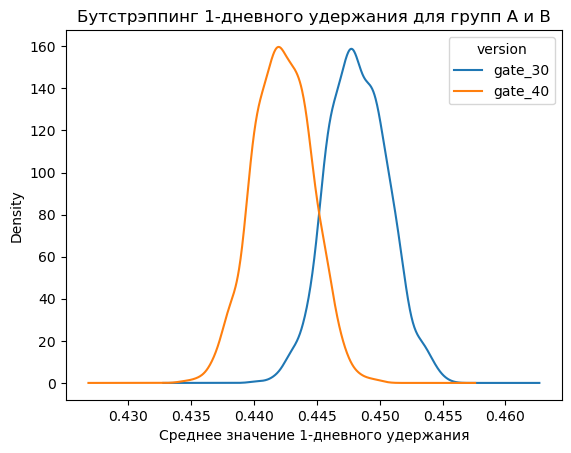

In [74]:
boot_1d = []
iterations = 1000
for i in range(iterations):
    boot_mean = df.sample(frac = 1, replace = True).groupby(
        'version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
boot_1d = pd.DataFrame(boot_1d)
    
ax = boot_1d.plot.kde()
ax.set_title('Бутстрэппинг 1-дневного удержания для групп A и B')
ax.set_xlabel('Среднее значение 1-дневного удержания');

Глядя на среднее значение удержания за 1 день, кажется, что размещение ворот на уровне 30 лучше, чем на уровне 40. Но за 1 день не так много игроков достигают этих уровней. Таким образом, требуется анализ 7-дневного удержания, так как больше людей могут достичь 30-го или 40-го уровня за 7 дней.

In [75]:
prop_gate30_7d = len(players_g30[players_g30['retention_7'] == True])/len(players_g30['retention_7']) * 100
prop_gate40_7d = len(players_g40[players_g40['retention_7'] == True])/len(players_g40['retention_7']) * 100

print('Недельное удержание контрольной группы (ворота на уровне 30):',str(round(prop_gate30_7d,2)),"%","\n", 
     'Недельное удержание тестовой группы (ворота на уровне 40):',str(round(prop_gate40_7d,2)),"%")

Недельное удержание контрольной группы (ворота на уровне 30): 19.02 % 
 Недельное удержание тестовой группы (ворота на уровне 40): 18.2 %


Как и в случае с 1-дневным удержанием, мы видим, что 7-дневное удержание немного ниже (18,2%), когда ворота находятся на 40-м уровне, чем когда ворота находятся на 30-м уровне (19,0%). Эта разница даже больше, чем для однодневного удержания, предположительно, потому, что больше игроков успели достич первых ворот. Мы также видим, что общее 7-дневное удержание ниже, чем общее 1-дневное удержание; меньше людей играют в игру через неделю после установки, чем через день после установки.

Но, как и прежде, воспользуемся бутстрэппингом, чтобы выяснить, насколько мы можем быть уверены в различии между группами.

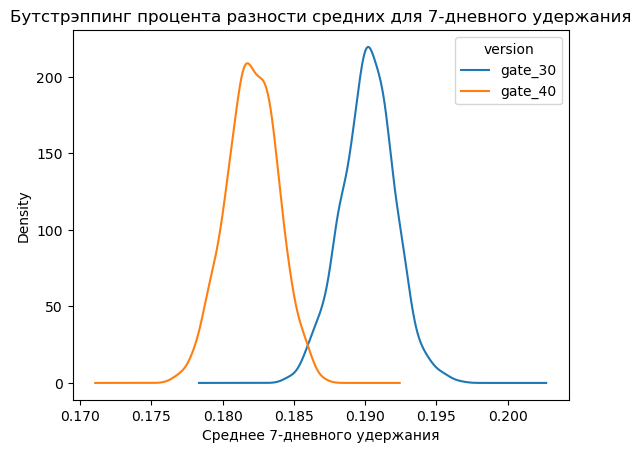

In [80]:
bootStrapMeanSevenDays = []
for i in range(1000):
    mean = df.sample(frac = 1, replace = True).groupby('version')['retention_7'].mean()
    bootStrapMeanSevenDays.append(mean)
bootStrapMeanSevenDays = pd.DataFrame(bootStrapMeanSevenDays)

ax = bootStrapMeanSevenDays.plot.kde()
ax.set_xlabel("Cреднее значение 7-дневного удержания")
ax.set_title('Бутстрэппинг процента разности средних для 7-дневного удержания');

Результат bootstrap дает убедительные доказательства того, что 7-дневное удержание выше, когда ворота находятся на уровне 30, чем когда они находятся на уровне 40.<br>
Проведенный анализ пказывает, что **нулевую гипотезу о том, что "Перенос ворот в игре с 30-го на 40-й уровень не имеет статистически значимого влияния на удержание игроков" мы вынужденны отвергнуть**.

### Выводы
Если мы хотим сохранить удержание на высоком уровне — как 1-дневное, так и 7-дневное — нам не следует перемещать ворота с 30-го уровня на 40-й. Конечно, есть и другие показатели, на которые мы могли бы обратить внимание, например, количество сыгранных игровых раундов или количество внутриигровых покупок, сделанных двумя AB-группами. Но удержание - один из самых важных показателей. Если мы не сохраним нашу базу игроков, не имеет значения, сколько денег они тратят в игре.

### Рекомендации
Ворота должны быть размещены на уровне 30 для лучшего показателя удержания в течение 1 и 7 дней.<br>
Однако многие игроки (~4000) не прошли ни одного уровня игры. Это следует проанализировать в рамках других исследований, так как у этого может быть несколько причин.